# Figure Generation Code: planet_tile2img

In [16]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import numpy as np

import xarray as xr
from rasterio.plot import show

from datetime import datetime
import csv

## Build Velocity Rastor Comparison Between S2 and PS

In [4]:
# Import Velocity Rastors
S2_raster_path = '/Volumes/Gendreau/SGlacier/SK_vmaps_2020_2021/velocity_20200904_20200914_100m_S2.tif'
PS_raster_path = '/Volumes/Gendreau/SGlacier/autorift_OUTPUT_PSsurge/velocity_20200906_20200912_100m_PS.tif'

#specify plot params
fs = 18
tickspacing = 100
y1 = 90; y2 = 360
x1 = 90; x2 = 360

#sentinel2
reader = rio.open(S2_raster_path);
S2r = reader.read(3);
imgres = reader.transform[0]
xdS2, ydS2 = S2r.shape
xS2_utms = np.arange(reader.bounds.left+imgres,reader.bounds.right+imgres*2,tickspacing*imgres).astype(int)/1000
yS2_utms = np.flip(np.arange(reader.bounds.bottom+imgres,reader.bounds.top+imgres*2,tickspacing*imgres).astype(int)/1000)

# Adjusting Tick Marks
xS2_utms = np.insert(xS2_utms, 0, 0) 
yS2_utms = np.insert(yS2_utms, 0, 0)

print('xS2', xS2_utms)
print('yS2', yS2_utms)

#planetscope
reader = rio.open(PS_raster_path); PSr = reader.read(3)
PSr = reader.read(3);
imgres = reader.transform[0]
xdPS, ydPS = PSr.shape
xPS_utms = np.arange(reader.bounds.left+imgres,reader.bounds.right+imgres*2,tickspacing*imgres).astype(int)/1000
yPS_utms = np.flip(np.arange(reader.bounds.bottom+imgres,reader.bounds.top+imgres*2,tickspacing*imgres).astype(int)/1000)

# Adjusting Tick Marks
xPS_utms = np.insert(xPS_utms, 0, 0) 
yPS_utms = np.insert(yPS_utms, 0, 0)

print('xPS', xPS_utms)
print('yPS', yPS_utms)

S2r_data = S2r.copy() # make a copy of the data
PSr_data = PSr.copy() # make a copy of the data
    
# Subtract The Rasters
difference_raster = S2r_data - PSr_data


xS2 [  0.    546.187 556.187 566.187 576.187 586.187]
yS2 [   0.    6681.592 6671.592 6661.592 6651.592 6641.592]
xPS [  0.    546.187 556.187 566.187 576.187 586.187]
yPS [   0.    6681.592 6671.592 6661.592 6651.592 6641.592]


/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_12793/2309689271.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xS2_utms, rotation=45)
/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_12793/2309689271.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(yS2_utms)
/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_12793/2309689271.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xS2_utms, rotation=45)
/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_12793/2309689271.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(yS2_utms)


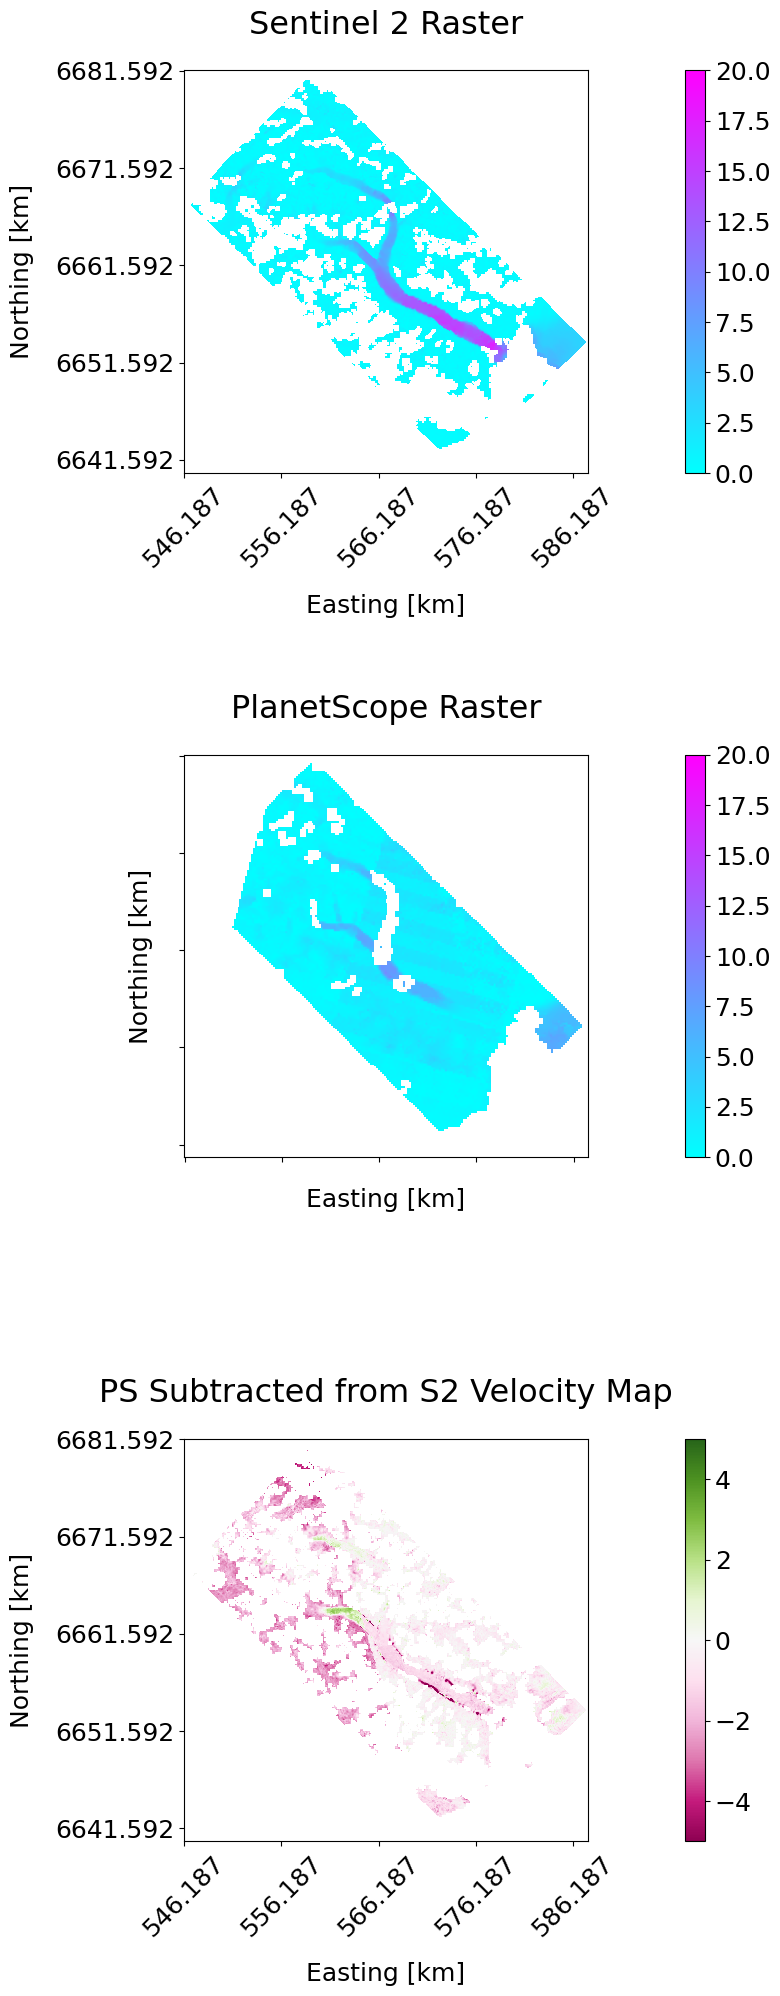

In [11]:
# Build Figures
#fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(25, 23))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 23))

# Set the spacing between subplots
plt.subplots_adjust(hspace=0.7)

#sentinel 2
im1 = ax1.imshow(S2r/365, vmin=0, vmax=20, cmap='cool'); ax1.set_title('Sentinel 2 Raster', fontsize=fs+5, y = 1.07); cbar = fig.colorbar(im1,ax=ax1)
cbar.ax.tick_params(labelsize = fs)
# ticks and labels:
plt.sca(ax1)
# plt.xticks(np.arange(x1,x2,tickspacing), labels = xS2_utms, rotation=90)
# plt.yticks(np.arange(y1,y2,tickspacing), labels = yS2_utms)
ax1.set_xticklabels(xS2_utms, rotation=45)
ax1.set_yticklabels(yS2_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#planetscope
im2 = ax2.imshow(PSr/365, vmin=0, vmax=20, cmap='cool'); ax2.set_title('PlanetScope Raster', fontsize=fs+5, y = 1.07); cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize = fs)
# ticks and labels:
plt.sca(ax2)
# plt.xticks(np.arange(x1,x2,tickspacing), labels = xPS_utms, rotation=90)
# plt.yticks(np.arange(y1,y2,tickspacing), labels = yPS_utms)
ax2.set_xticklabels(xPS_utms, rotation=45)
ax2.set_yticklabels(yPS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#difference raster
im3 = ax3.imshow(difference_raster/365,vmin=-5, vmax=5, cmap='PiYG'); ax3.set_title('PS Subtracted from S2 Velocity Map', fontsize=fs+5, y = 1.07); cbar = fig.colorbar(im3,ax=ax3)
cbar.ax.tick_params(labelsize = fs)
# ticks and labels:
plt.sca(ax3)
# plt.xticks(np.arange(x1,x2,tickspacing), labels = xS2_utms, rotation=90)
# plt.yticks(np.arange(y1,y2,tickspacing), labels = yS2_utms)
ax3.set_xticklabels(xS2_utms, rotation=45)
ax3.set_yticklabels(yS2_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)   

# Save the figure (one at a time)
plt.savefig('/Users/maddiegendreau/Desktop/PS_S2_Velocity_Difference.png', dpi=300)
#plt.savefig('/Users/maddiegendreau/Desktop/PS_S2_Velocity_Difference.pdf')


## Build Velocity Raster Comparison Between LS and PS

In [5]:
# Import Velocity Rastors
LS_raster_path = '/Volumes/Gendreau/Desktop/velocity_20200401_20200410_200m_LS.tif'
PS_raster_path = '/Volumes/Gendreau/SGlacier/autorift_OUTPUT_PSsurge_SK/velocity_20200329_20200411_200m_PS.tif'

#specify plot params
fs = 18
tickspacing = 50
y1 = 90; y2 = 360
x1 = 90; x2 = 360

#Landsat
reader = rio.open(LS_raster_path);
LSr = reader.read(2);
imgres = reader.transform[0]
xdLS, ydLS = LSr.shape
xLS_utms = np.arange(reader.bounds.left+imgres,reader.bounds.right+imgres*2,tickspacing*imgres).astype(int)/1000
yLS_utms = np.flip(np.arange(reader.bounds.bottom+imgres,reader.bounds.top+imgres*2,tickspacing*imgres).astype(int)/1000)

# Adjusting Tick Marks
xLS_utms = np.insert(xLS_utms, 0, 0) 
yLS_utms = np.insert(yLS_utms, 0, 0)

print(xLS_utms)
print('yLS', yLS_utms)


#planetscope
reader = rio.open(PS_raster_path); PSr = reader.read(3)
PSr = reader.read(3);
imgres = reader.transform[0]
xdPS, ydPS = PSr.shape
xPS_utms = np.arange(reader.bounds[0]+imgres,reader.bounds[0]+imgres,tickspacing*imgres).astype(int)/1000
yPS_utms = np.flip(np.arange(reader.bounds[1]+imgres,reader.bounds[1]+imgres,tickspacing*imgres).astype(int)/1000)

LSr_data = LSr.copy() # make a copy of the data
PSr_data = PSr.copy() # make a copy of the data
    
# Subtract The Rasters
difference_raster_2 = LSr_data - PSr_data


[  0.    546.287 556.287 566.287 576.287 586.287]
yLS [   0.    6681.692 6671.692 6661.692 6651.692 6641.692]


/var/folders/w2/gynrq9b15j71697l2kpp486nh9ztq2/T/ipykernel_89894/2949075313.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xLS_utms)
/var/folders/w2/gynrq9b15j71697l2kpp486nh9ztq2/T/ipykernel_89894/2949075313.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(yLS_utms)


[  0.    546.287 556.287 566.287 576.287 586.287]


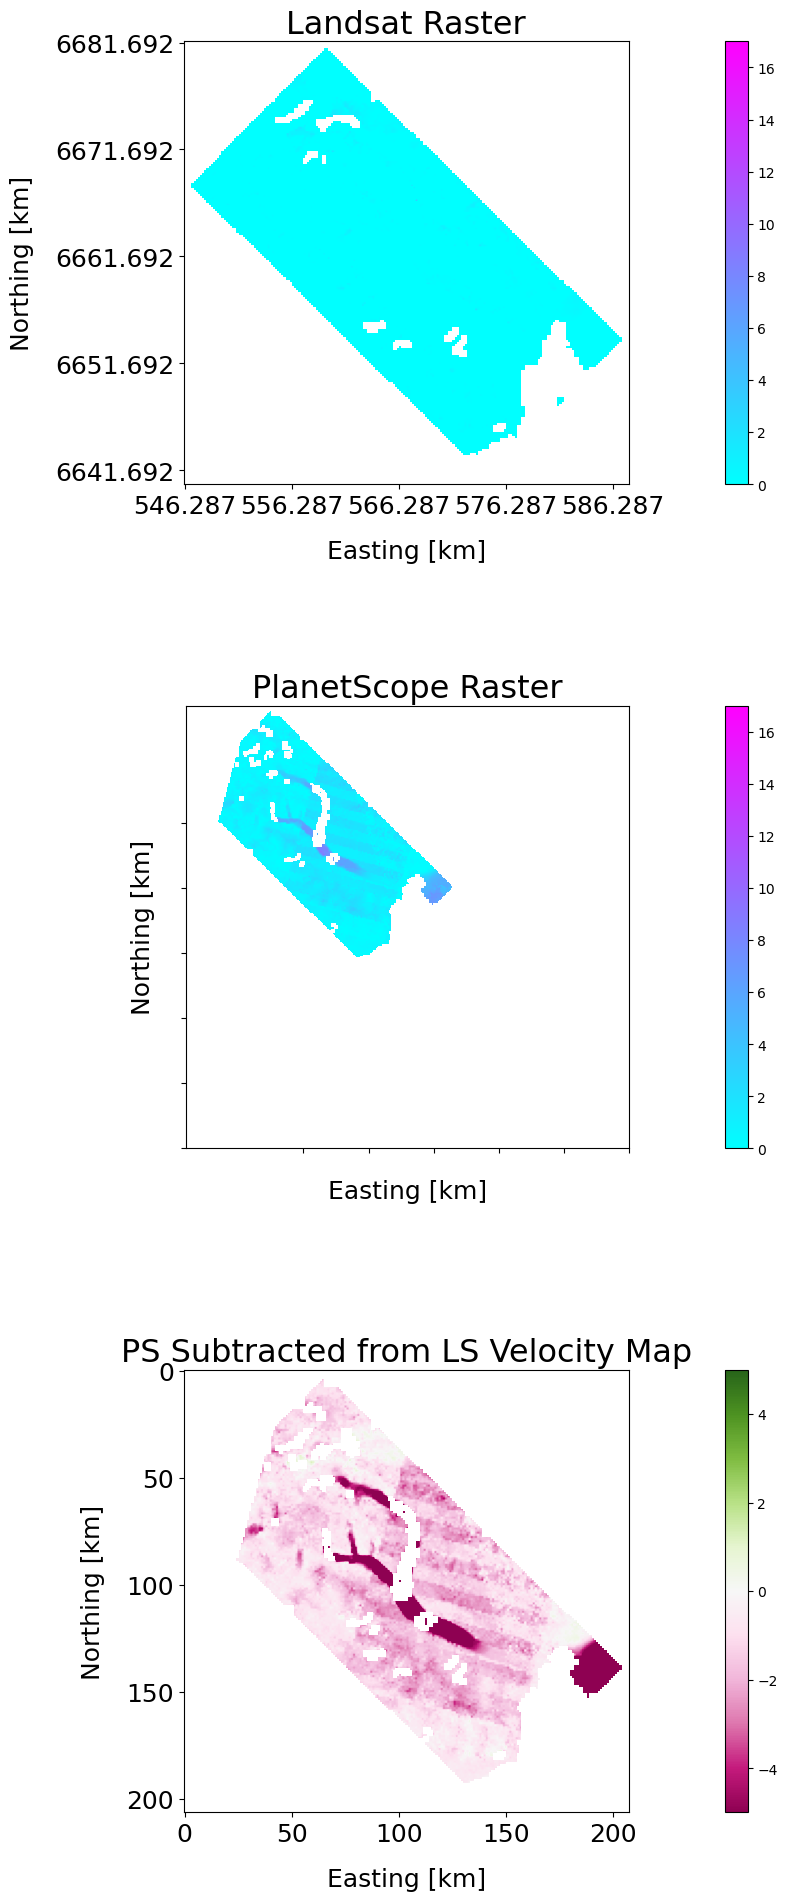

In [19]:
# Build Figures
#fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(25, 23))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 23))

# Set the spacing between subplots
plt.subplots_adjust(hspace=0.5)

#Landsat
im1 = ax1.imshow(LSr/365, vmin=0, vmax=17, cmap='cool'); ax1.set_title('Landsat Raster', fontsize=fs+5); fig.colorbar(im1,ax=ax1)
# ticks and labels:
plt.sca(ax1)
# plt.xticks(np.arange(x1,x2,tickspacing), labels = xLS_utms, rotation=90)
ax1.set_xticklabels(xLS_utms)
print(xLS_utms)
ax1.set_yticklabels(yLS_utms)
# plt.yticks(np.arange(y1,y2,tickspacing), labels = yLS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#planetscope
im2 = ax2.imshow(PSr/365, vmin=0, vmax=17, cmap='cool'); ax2.set_title('PlanetScope Raster', fontsize=fs+5); fig.colorbar(im2, ax=ax2)
# ticks and labels:
plt.sca(ax2)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xPS_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yPS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#difference raster
im3 = ax3.imshow(difference_raster_2/365,vmin=-5, vmax=5, cmap='PiYG'); ax3.set_title('PS Subtracted from LS Velocity Map', fontsize=fs+5); fig.colorbar(im3,ax=ax3)
# ticks and labels:
plt.sca(ax3)
# plt.xticks(np.arange(x1,x2,tickspacing), labels = xLS_utms, rotation=90)
# plt.yticks(np.arange(y1,y2,tickspacing), labels = yLS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)   

# Save the figure
#plt.savefig('/Users/maddiegendreau/Desktop/test_plot.png', dpi=300)


## Generate Errors BoxPlot

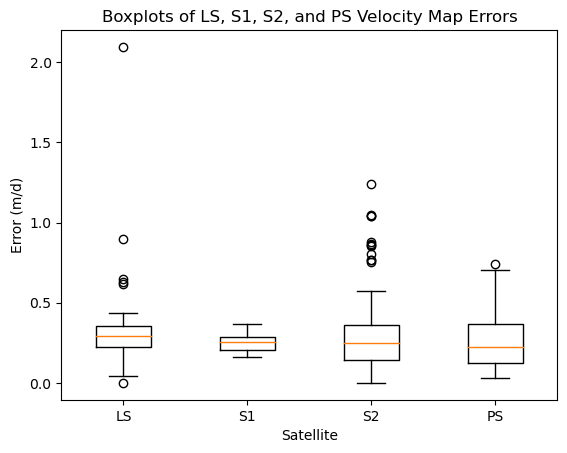

In [6]:
# Generate BoxPlot

data1 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/LS_Data.csv')['err_v']
data2 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/S1_Data.csv')['err_v']
data3 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/S2_Data.csv')['err_v']
data4 = pd.read_csv('/Volumes/Gendreau/Documents/new_csv/PS_new.csv')['err_v']

data = [data1, data2, data3, data4]

positions = [1, 2, 3, 4]
labels = ['LS', 'S1', 'S2', 'PS']
plt.boxplot(data, positions=positions, labels=labels)

plt.xlabel('Satellite')
plt.ylabel('Error (m/d)')
plt.title('Boxplots of LS, S1, S2, and PS Velocity Map Errors')
#plt.show()

# Save the figure, you'll need to change the path to the desired figure location
plt.savefig('/Users/maddiegendreau/Desktop/BoxPlot_Figure.png')

## PlanetScope Histogram of Date Seperation

In [3]:
folder_path = '/Volumes/Gendreau/SGlacier/autorift_OUTPUT_PSsurge_SK/'

folder = os.listdir(folder_path)

prefix = "velocity"
suffix = "100m_PS.tif"

for file in folder:
    if file.startswith(prefix) and file.endswith(suffix):
        print(file)
        
        split_name_1 = file.split("_")[1]
        split_name_2 = file.split("_")[2]

        
        date_string1 = split_name_1
        date_string2 = split_name_2
      
        
        date1 = datetime.strptime(date_string1, '%Y%m%d')
        date2 = datetime.strptime(date_string2, '%Y%m%d')
       
        
        date_strings = date1, date2
        
        print(date_strings)
        
        # Calculate the time separation in days
        time_separation = (date2 - date1).days

        # Print the result
        print("Time separation in days:", time_separation)
        
        # Assuming you have the datetime object and the additional information
        dt = date1
        additional_info = time_separation
        
        print("dt",dt)
        print("add info", additional_info)
        
        # Specify the format for year and month
        format_str = "%Y-%m"

        # Save the data in a list
        data_row = [dt.strftime(format_str), str(additional_info)]
        
        print("date row", data_row)

        # Specify the CSV file path
        csv_file_path = "/Users/maddiegendreau/Desktop/date_output_PS.csv"

        # Write the data to the CSV file
        with open(csv_file_path, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            #writer.writerow(["Date", "Date Separation"])  # Write the header row
            writer.writerow(data_row)  # Write the data row

        print("Data saved to the CSV file:", csv_file_path)

velocity_20211010_20211016_100m_PS.tif
(datetime.datetime(2021, 10, 10, 0, 0), datetime.datetime(2021, 10, 16, 0, 0))
Time separation in days: 6
dt 2021-10-10 00:00:00
add info 6
date row ['2021-10', '6']
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_PS.csv
velocity_20200627_20200805_100m_PS.tif
(datetime.datetime(2020, 6, 27, 0, 0), datetime.datetime(2020, 8, 5, 0, 0))
Time separation in days: 39
dt 2020-06-27 00:00:00
add info 39
date row ['2020-06', '39']
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_PS.csv
velocity_20210617_20210629_100m_PS.tif
(datetime.datetime(2021, 6, 17, 0, 0), datetime.datetime(2021, 6, 29, 0, 0))
Time separation in days: 12
dt 2021-06-17 00:00:00
add info 12
date row ['2021-06', '12']
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_PS.csv
velocity_20200329_20200411_100m_PS.tif
(datetime.datetime(2020, 3, 29, 0, 0), datetime.datetime(2020, 4, 11, 0, 0))
Time separation in days: 13
dt 2020-0

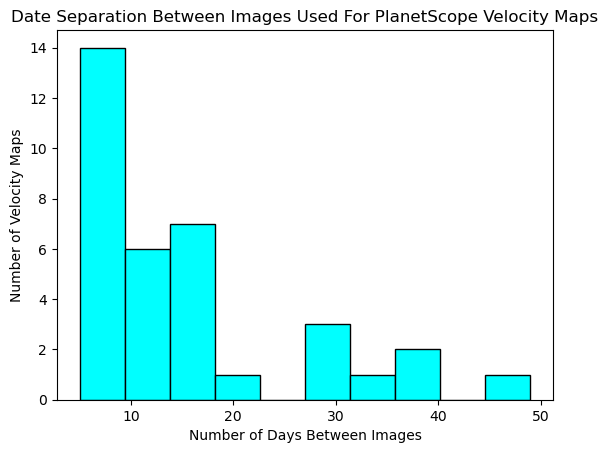

In [8]:
# Make Date Separation Histogram

# Read the CSV file
Counts = pd.read_csv('/Volumes/Gendreau/Desktop/date_output_PS.csv')['Date Separation']

# Generate plot
plt.hist(Counts, color ='cyan', edgecolor='black')

# Customize the plot
plt.xlabel('Number of Days Between Images')
plt.ylabel('Number of Velocity Maps')
plt.title('Date Separation Between Images Used For PlanetScope Velocity Maps')

# Display the histogram
#plt.show()

# Save the figure, you'll need to change the path to the desired figure location
plt.savefig('/Users/maddiegendreau/Desktop/PS_Date_Separation_Histogram.png')

# Make Histogram/Bar Graph of Velocity Maps per Month

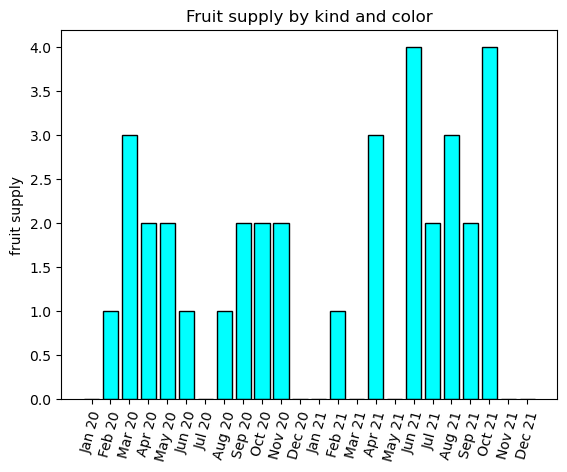

In [31]:
fig, ax = plt.subplots()

fruits = ['Jan 20', 'Feb 20', 'Mar 20', 'Apr 20', 'May 20', 'Jun 20', 'Jul 20', 'Aug 20', 'Sep 20', 'Oct 20', 'Nov 20', 'Dec 20', 'Jan 21', 'Feb 21', 'Mar 21', 'Apr 21', 'May 21', 'Jun 21', 'Jul 21', 'Aug 21', 'Sep 21', 'Oct 21', 'Nov 21', 'Dec 21']
counts = [0, 1, 3, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 0, 3, 0, 4, 2, 3, 2, 4, 0, 0]
bar_labels = ['Jan 20', 'Feb 20', 'Mar 20', 'Apr 20', 'May 20', 'Jun 20', 'Jul 20', 'Aug 20', 'Sep 20', 'Oct 20', 'Nov 20', 'Dec 20', 'Jan 21', 'Feb 21', 'Mar 21', 'Apr 21', 'May 21', 'Jun 21', 'Jul 21', 'Aug 21', 'Sep 21', 'Oct 21', 'Nov 21', 'Dec 21']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(fruits, counts, label=bar_labels, color ='cyan', edgecolor='black')

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
plt.xticks(rotation = 75)
#ax.legend(title='Fruit color')

plt.show()

In [6]:
# SECOND ATTEMPT AT Make Velocity Maps Per Month Histogram

# We want x to be the months of the year as the bins
x = [datetime.datetime(2010, 12, 1, 10, 0),
    datetime.datetime(2011, 1, 4, 9, 0),
    datetime.datetime(2011, 5, 5, 9, 0)]

print('x', x)

# We want y to be the data for the bar plot
y = [4, 9, 2]

ax = plt.subplot(111)
ax.bar(x, y, width=10)
ax.xaxis_date()

plt.show()

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

0     2021-10
1     2020-06
2     2021-06
3     2020-03
4     2021-04
5     2021-04
6     2020-09
7     2020-09
8     2021-08
9     2021-04
10    2021-09
11    2021-08
12    2020-08
13    2020-04
14    2021-02
15    2020-11
16    2021-08
17    2020-02
18    2021-09
19    2021-07
20    2021-06
21    2020-05
22    2020-04
23    2021-06
24    2020-11
25    2020-03
26    2020-10
27    2020-05
28    2020-03
29    2020-10
30    2021-07
31    2021-10
32    2021-10
33    2021-10
34    2021-06
Name: First Date, dtype: object


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (35,).

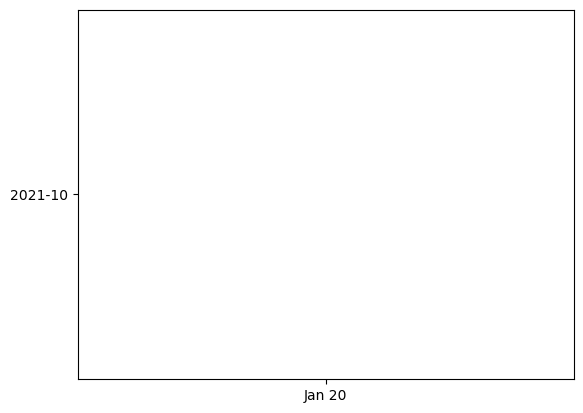

In [13]:
# Read the CSV file
Dates = pd.read_csv('/Volumes/Gendreau/Desktop/date_output_PS.csv')['First Date']

print(Dates)

fig, ax = plt.subplots()

# fruits = ['Jan 20', 'Feb 20', 'Mar 20', 'Apr 20']
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(fruits, Dates)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')

plt.show()

/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_58405/4251828221.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(infile, parse_dates=['First Date'], date_parser=dateparse, usecols = ['First Date'])


TypeError: the dtypes of parameters x (datetime64[ns]) and width (int64) are incompatible

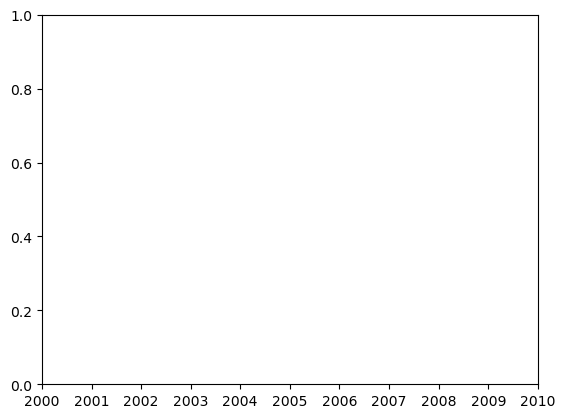

In [9]:
# Read the CSV file
infile = '/Volumes/Gendreau/Desktop/date_output_PS.csv'
dateparse = lambda x: datetime.strptime(x, '%Y-%m')
df = pd.read_csv(infile, parse_dates=['First Date'], date_parser=dateparse, usecols = ['First Date'])
data = df

# print('dates', data)

y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

ax = plt.subplot(111)
ax.bar(data, y, width=10)
ax.xaxis_date()


In [2]:
# Make Velocity Maps Per Month Histogram

# Read the CSV file
infile = '/Volumes/Gendreau/Desktop/date_output_PS.csv'
dateparse = lambda x: datetime.strptime(x, '%Y-%m')
df = pd.read_csv(infile, parse_dates=['First Date'], date_parser=dateparse, usecols = ['First Date'])
data = df

print('dates', dates)

# Read the Month file for making the histogram
# month_file = '/Users/maddiegendreau/Desktop/Date_List.csv'
# dateparse = lambda x: datetime.strptime(x, '%Y-%m')
# mf = pd.read_csv(month_file, parse_dates=['month'], date_parser=dateparse, usecols = ['month'])
#print('months', month)

# Make histogram
# plt.hist(data, color ='cyan', edgecolor='black', bins = 24)
# plt.xticks(rotation = 45)
# ax.set_xticks(data)

fig, ax = plt.subplots()
counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray', bins = 23)
plt.xticks(rotation = 45)
ax.set_xticks(bins)

/var/folders/98/rkqg3rzn5dxdk5kjj0n7snnm0000gn/T/ipykernel_58405/1538130660.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(infile, parse_dates=['First Date'], date_parser=dateparse, usecols = ['First Date'])


NameError: name 'dates' is not defined

## DO NOT USE

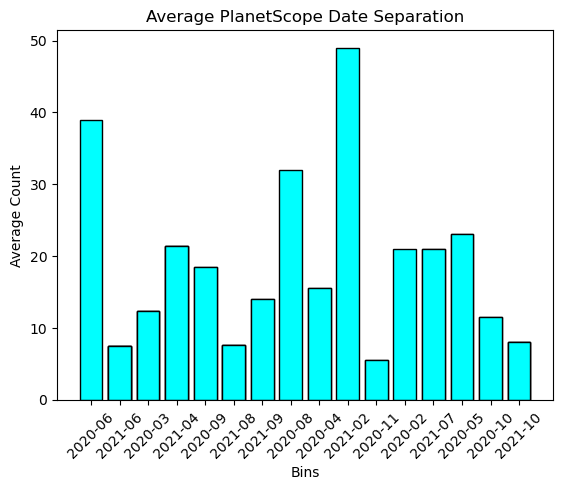

In [162]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/Users/maddiegendreau/Desktop/date_output_PS.csv')

# Extract the data from the first and second columns
bins = data.iloc[:, 0]
counts = data.iloc[:, 1]

# Set the bin labels
bin_labels = bins.astype(str)

# Create an empty dictionary to store the averaged counts
averages = {}

# Iterate over each bin
for bin_value, count in zip(bins, counts):
    bin_value = str(bin_value)
    if bin_value in averages:
        # If the bin already exists in the dictionary, update the count and number of occurrences
        averages[bin_value]['count'] += count
        averages[bin_value]['occurrences'] += 1
    else:
        # If the bin doesn't exist in the dictionary, initialize it with the count and occurrences
        averages[bin_value] = {'count': count, 'occurrences': 1}

# Calculate the average count for each bin
bin_averages = [averages[bin_value]['count'] / averages[bin_value]['occurrences'] for bin_value in bin_labels]

# Create a histogram with averaged counts
plt.bar(bin_labels, bin_averages, color ='cyan', edgecolor='black')

# Customize the plot
plt.xlabel('Bins')
plt.ylabel('Average Count')
plt.title('Average PlanetScope Date Separation')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the histogram
plt.show()

#plt.savefig('figure.png')

## Landsat and Sentinel Histogram of Date Separation

In [9]:
folder_path = '/Volumes/Gendreau/SGlacier/SK_vmaps_2020_2021/'

folder = os.listdir(folder_path)

prefix = "velocity"
suffix = ("100m_S2.tif","100m_S1.tif","100m_LS.tif")

for file in folder:
    if file.startswith(prefix) and file.endswith(suffix):
        print(file)
        
        split_name_1 = file.split("_")[1]
        split_name_2 = file.split("_")[2]

        
        date_string1 = split_name_1
        date_string2 = split_name_2
      
        
        date1 = datetime.strptime(date_string1, '%Y%m%d')
        date2 = datetime.strptime(date_string2, '%Y%m%d')
        date_strings = date1, date2
        
        
        # Calculate the time separation in days
        time_separation = (date2 - date1).days

        # Print the result
        print("Time separation in days:", time_separation)
        
        # Assuming you have the datetime object and the additional information
        dt = date1
        additional_info = time_separation
        
        # Specify the format for year and month
        format_str = "%Y-%m"

        # Save the data in a list
        data_row = [dt.strftime(format_str), str(additional_info)]

        # Specify the CSV file path
        csv_file_path = "/Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv"

        # Write the data to the CSV file
        with open(csv_file_path, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            #writer.writerow(["Date", "Date Separation"])  # Write the header row
            writer.writerow(data_row)  # Write the data row

        print("Data saved to the CSV file:", csv_file_path)

velocity_20200914_20200924_100m_S2.tif
Time separation in days: 10
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20200904_20200914_100m_S2.tif
Time separation in days: 10
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20210104_20210116_100m_S1.tif
Time separation in days: 12
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20200924_20201017_100m_S2.tif
Time separation in days: 23
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20200818_20200904_100m_S2.tif
Time separation in days: 17
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20210204_20210211_100m_S2.tif
Time separation in days: 7
Data saved to the CSV file: /Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv
velocity_20210211_20210402_100m_S2.tif
Time separation in days: 50
Data saved to the CSV file: /Users

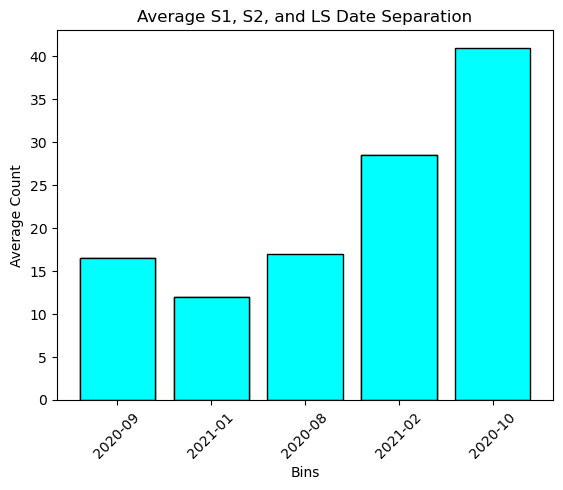

In [10]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/Users/maddiegendreau/Desktop/date_output_S1_S2_LS.csv')

# Extract the data from the first and second columns
bins = data.iloc[:, 0]
counts = data.iloc[:, 1]

# Set the bin labels
bin_labels = bins.astype(str)

# Create an empty dictionary to store the averaged counts
averages = {}

# Iterate over each bin
for bin_value, count in zip(bins, counts):
    bin_value = str(bin_value)
    if bin_value in averages:
        # If the bin already exists in the dictionary, update the count and number of occurrences
        averages[bin_value]['count'] += count
        averages[bin_value]['occurrences'] += 1
    else:
        # If the bin doesn't exist in the dictionary, initialize it with the count and occurrences
        averages[bin_value] = {'count': count, 'occurrences': 1}

# Calculate the average count for each bin
bin_averages = [averages[bin_value]['count'] / averages[bin_value]['occurrences'] for bin_value in bin_labels]

# Create a histogram with averaged counts
plt.bar(bin_labels, bin_averages, color ='cyan', edgecolor='black')

# Customize the plot
plt.xlabel('Bins')
plt.ylabel('Average Count')
plt.title('Average S1, S2, and LS Date Separation')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the histogram
plt.show()

#plt.savefig('figure.png')